# BioImageIO Crowd Sourcing Demo

This notebook runs a BioEngine server equipped with Kaibu, an interactive image annotation tool in the browser. It allows the annotation of images in a collaborative manner.

As a demo, we will collect image annotations from the participants and train a CellPose model using dose.
Most of the notebook is based on the original [CellPose notebook](https://github.com/mouseland/cellpose)

# 0. Setup

We will first install all the dependencies required for Kaibu, ImJoy and cellpose 2.0, check the GPU is working, and mount google drive to get your models and images.

## Installation
Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

Please, restart the session afetr installing the requirements.

In [ ]:
## Install required dependencies

!git clone https://github.com/bioimage-io/bioimageio-colab.git
!pip install -r "/content/bioimageio-colab/requirements-colab.txt"

# !pip install numpy==1.26.4
# !pip install imjoy-rpc==0.5.48.post2
# !pip install requests==2.31.0
# !pip install kaibu-utils==0.1.14
# !pip install tifffile
# !pip install matplotlib
# !pip install imjoy-jupyterlab-extension
# !pip install kaibu-utils
# !pip install "opencv-python-headless<4.3"
# !pip install cellpose

## Mount google drive

Please mount your google drive and find your working folder with (if available) the model that you trained. If you want to train a model, create a folder in google drive with the images and the labels, either `_seg.npy` files from the cellpose gui, or `_masks.tif` files.

In [2]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')




Mounted at /content/gdrive


# 1. Launch the BioEngine for Collaborative annotations

## Download the example dataset

In [ ]:
!wget "https://github.com/bioimage-io/bioimageio-colab/releases/download/v0.1/hpa-dataset-v2-98-rgb.zip"
!mkdir "data"
!unzip hpa-dataset-v2-98-rgb.zip -d data/

## Launch a BioEngine server

In [1]:
import os
from imjoy_rpc.hypha import connect_to_server
import numpy as np
# Prepare paths for output
from tifffile import imread, imwrite
from kaibu_utils import fetch_image, features_to_mask
import urllib


#!wget "https://github.com/bioimage-io/bioimageio-colab/releases/download/v0.1/hpa-dataset-v2-98-rgb.zip"
#!mkdir "data"
#!unzip hpa-dataset-v2-98-rgb.zip -d data/

path2data = "/content/data"
outpath = "/content/gdrive/MyDrive/HENRIQUES LAB/PROJECTS/BIOIMAGE MODEL ZOO/kaibu_annotations"
os.makedirs(outpath, exist_ok=True)

training_images = []

path2label = os.path.join(outpath, "labels")
os.makedirs(path2label, exist_ok=True)

path2source = os.path.join(outpath, "source")
os.makedirs(path2source, exist_ok=True)
# Connect to the server link
server_url = "https://ai.imjoy.io"
server = await connect_to_server({"server_url": server_url})

# When multiple people open the link above, they can join a common workspace as an ImJoy client
def add_image(image, label):
    training_images.append((image, label))
    print(f"{len(training_images)} available already.")
    return

def get_random_image():
    filenames = [f for f in os.listdir(path2data) if f.endswith(".tif")]
    n = np.random.randint(len(filenames)-1)
    image = imread(os.path.join(path2data, filenames[n]))
    if len(image.shape)==3 and image.shape[0]==3:
        image = np.transpose(image, [1,2,0])
    #print(image.shape)
    new_filename = f"{len(os.listdir(path2source)) + 1}_{filenames[n]}"


    return image, filenames[n], new_filename,

def save_annotation(filename, newname, features, image_shape):
    mask = features_to_mask(features, image_shape)
    image = imread(os.path.join(path2data, filename))
    if len(image.shape)==3 and image.shape[0]==3:
        image = np.transpose(image, [1,2,0])
    imwrite(os.path.join(path2source, newname), image)
    imwrite(os.path.join(path2label, newname), mask)


svc = await server.register_service({
    "name": "Model Trainer",
    "id": "bioimageio-colab",
    "config": {
        "visibility": "public"
    },
    "get_random_image": get_random_image,
    "save_annotation": save_annotation,

})
sid = svc['id']
config_str = f'{{"service_id": "{sid}", "server_url": "{server_url}"}}'
encoded_config = urllib.parse.quote(config_str, safe='/', encoding=None, errors=None)
annotator_url = f'https://imjoy.io/lite?plugin=https://raw.githubusercontent.com/bioimage-io/bioimageio-colab/main/plugins/bioimageio-colab.imjoy.html&config=' + encoded_config
print(annotator_url)



https://imjoy.io/lite?plugin=https://raw.githubusercontent.com/bioimage-io/bioimageio-colab/main/plugins/bioimageio-colab.imjoy.html&config=%7B%22service_id%22%3A%20%22NvLQUbKSg2ECWJDr9br8kX/n5TcobNo7WS2ACXVB9B3fz%3Abioimageio-colab%22%2C%20%22server_url%22%3A%20%22https%3A//ai.imjoy.io%22%7D


## Display manual annotations

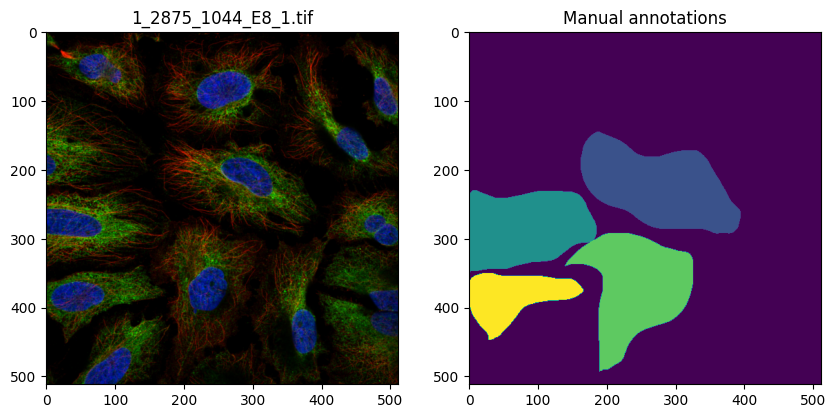

In [5]:
import matplotlib.pyplot as plt

path2label = os.path.join(outpath, "labels")
path2source = os.path.join(outpath, "source")
annotations = [f for f in os.listdir(path2source) if f.endswith(".tif")]
k=0

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(imread(os.path.join(path2source, annotations[k])))
plt.title(f"{annotations[k]}")
plt.subplot(1,2,2)
plt.imshow(imread(os.path.join(path2label, annotations[k])))
plt.title(f"Manual annotations")
plt.show()


In [14]:
## Split the dataset into training and test and reorganise them
import shutil
import os

training_folder = "/content/train"
test_folder = "/content/test"
os.makedirs(training_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)


#path2label = os.path.join(outpath, "labels")
#path2source = os.path.join(outpath, "source")

test_portion = 0.1
t = np.floor(test_portion * len(os.listdir(path2source)))
t = np.int16(t)
filenames = [f for f in os.listdir(os.path.join(path2source)) if f.endswith(".tif")]

for i in range(len(filenames)-t):
    shutil.copyfile(os.path.join(path2source, filenames[i]),
                    os.path.join(training_folder, filenames[i]))
    mask_name = filenames[i].split(".tif")[0]
    shutil.copyfile(os.path.join(path2label, filenames[i]),
                    os.path.join(training_folder, f"{mask_name}_seg.tif" ))

for i in range(len(filenames)-t, len(filenames)):
    shutil.copyfile(os.path.join(path2source, filenames[i]),
                    os.path.join(test_folder,filenames[i] ))
    mask_name = filenames[i].split(".tif")[0]
    shutil.copyfile(os.path.join(path2label, filenames[i]),
                    os.path.join(test_folder, f"{mask_name}_seg.tif" ))

print(f"Training images: {len(os.listdir(training_folder))/2}")
print(f"Test images: {len(os.listdir(test_folder))/2}")

Training images: 3.0
Test images: 2.0


# 2. Running cellpose 2.0 in colab with a GPU

<font size = 4>Cellpose 2.0 now allows you to train your own models in the GUI!

This notebook allows you to load this **custom model** and run the model on your images with a GPU.

In this notebook, you can also **train** a custom model using your labels (`_seg.npy`) files, or other labels as `_masks.tif` files. If you already have a trained model, skip this part of the notebook.

For more details on cellpose 2.0 check out the [paper](https://www.biorxiv.org/content/10.1101/2022.04.01.486764v1) or the [talk](https://www.youtube.com/watch?v=3ydtAhfq6H0).

Mount your google drive to access all your image files, segmentations, and custom models. This also ensures that any models you train are saved to your google drive. If you'd like to try out the notebook without your own files, please download the sample images from tissuenet (optional step in Setup below).

This notebook was inspired by the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories. Please check out their great work!

what the training images look like + their labels

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [15]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
/bin/bash: line 1: nvidia-smi: command not found
>>> GPU activated? NO


# Train model on manual annotations

Skip this step if you already have a pretrained model.

Fill out the form below with the paths to your data and the parameters to start training.

## Training parameters

<font size = 4> **Paths for training, predictions and results**


<font size = 4>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images). You can leave the test_dir blank, but it's recommended to have some test images to check the model's performance. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 4>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 4>**Training parameters**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [16]:
#@markdown ###Path to images and masks:

train_dir = "/content/train" #@param {type:"string"}
test_dir = "/content/test" #@param {type:"string"}
#Define where the patch file will be saved
base = "/content"

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto3" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "CP_HPA_CrowdSourcing" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  40#@param {type:"number"}

Channel_to_use_for_training = "Red" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "Blue" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


Here's what the command to train would be on the command line -- make sure if you run this locally to correct the paths for your local computer.

In [36]:
# run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay}'
# if test_dir is not None:
#     run_str += f' --test_dir {test_dir}'
# run_str += ' --mask_filter _seg.npy' # if you want to use _seg.npy files for training
# print(run_str)

python -m cellpose --use_gpu --verbose --train --dir /content/train --pretrained_model cyto3 --chan 1 --chan2 3 --n_epochs 10 --learning_rate 0.1 --weight_decay 0.0001 --mask_filter _seg.npy


## Train new model

Using settings from form above, train model in notebook.

In [17]:
from cellpose import train

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter="_seg")
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path = train.train_seg(model.net, train_data=train_data,
                              train_labels=train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=train_dir,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=3,
                              model_name=model_name,
                              min_train_masks=1)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

creating new log file


100%|██████████| 25.3M/25.3M [00:01<00:00, 26.4MB/s]
100%|██████████| 2/2 [00:00<00:00, 480.64it/s]


## Evaluate on test data (optional)

If you have test data, check performance

In [18]:
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter='_seg')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data,
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')



>>> average precision at iou threshold 0.5 = 0.000


plot masks

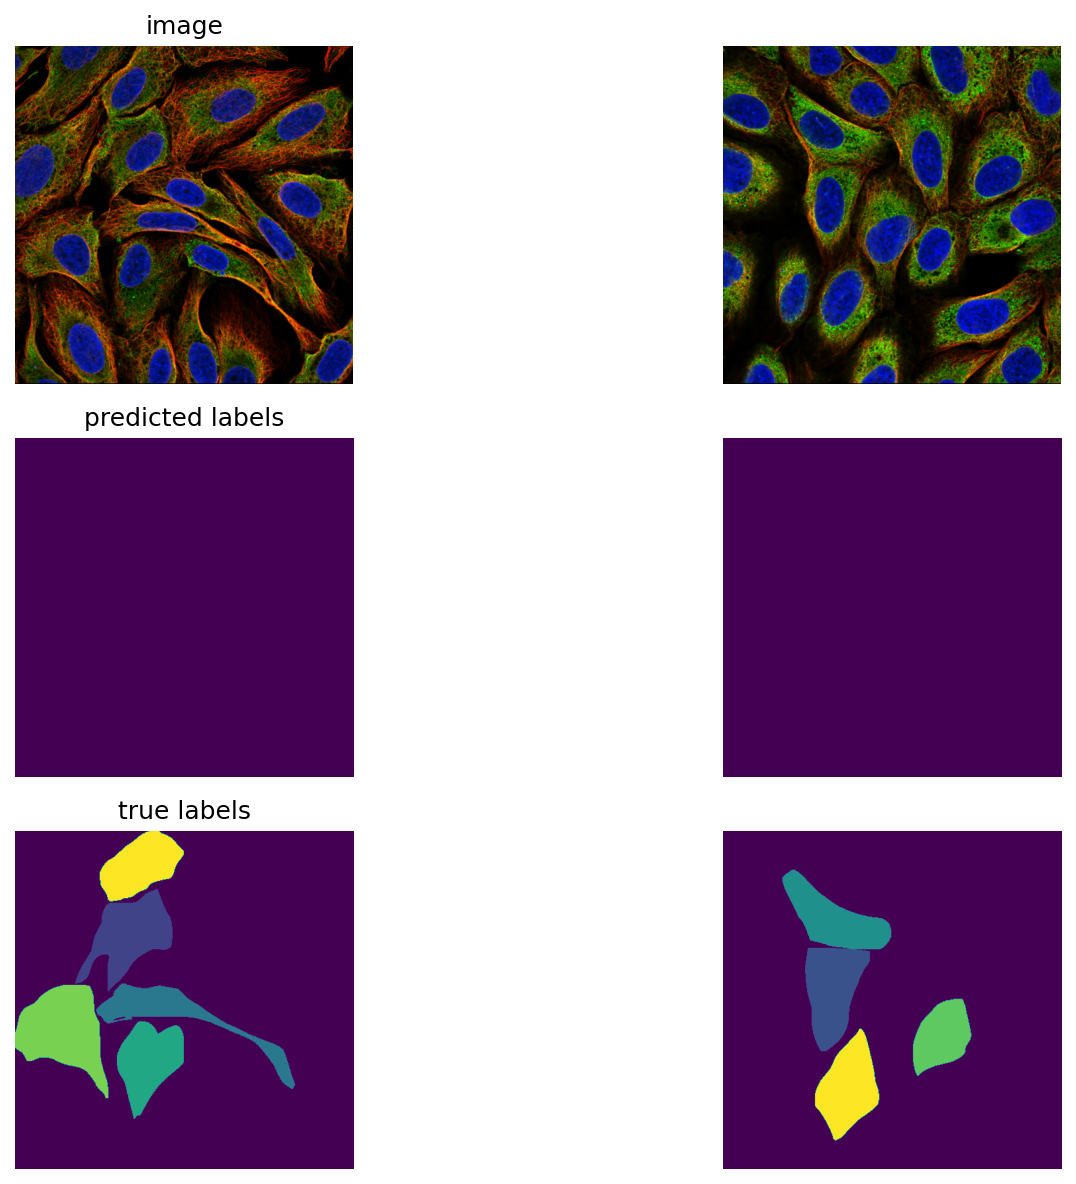

In [19]:
plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(test_data), k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    #img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(test_data), len(test_data) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(test_data), 2*len(test_data) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

# Use custom model to segment images

Take custom trained model from above, or upload your own model to google drive / colab runtime.

## Parameters

In [20]:
# model name and path

#@markdown ###Custom model path (full path):

model_path = "/content/train/models/CP_HPA_CrowdSourcing" #@param {type:"string"}

#@markdown ###Path to images:

dir = "/content/test" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Red" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "Blue" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  0#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}


if you're using the example test data we'll copy it to a new folder

In [24]:
src = 'human_in_the_loop/test'
if dir[:len(src)] == src:
    files = io.get_image_files(dir, '_masks')
    dir = 'human_in_the_loop/eval/'
    os.makedirs(dir, exist_ok=True)
    for f in files:
        dst = dir + os.path.split(f)[1]
        print(f'{f} > {dst}')
        shutil.copyfile(f, dst)

Here's what the command to train would be on the command line -- make sure if you run this locally to correct the paths for your local computer.

In [22]:
run_str = f'python -m cellpose --use_gpu --verbose --dir {dir} --pretrained_model {model_path} --chan {chan} --chan2 {chan2} --diameter {diameter} --flow_threshold {flow_threshold} --cellprob_threshold {cellprob_threshold}'
print(run_str)

python -m cellpose --use_gpu --verbose --dir /content/test --pretrained_model /content/train/models/CP_HPA_CrowdSourcing --chan 1 --chan2 3 --diameter 0 --flow_threshold 0.4 --cellprob_threshold 0


## run custom model

how to run the custom model in a notebook

In [25]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images,
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

['/content/test/2_46404_1377_A6_1.tif', '/content/test/2_46404_1377_A6_1_seg.tif', '/content/test/3_47746_1370_G11_1.tif', '/content/test/3_47746_1370_G11_1_seg.tif']


## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [26]:
from cellpose import io

io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      files,
                      channels=[chan, chan2],
                      diams=diameter*np.ones(len(masks)),
                      )

## save output masks to tiffs/pngs or txt files for imageJ

In [27]:
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )


In [ ]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output.png'))
plt.axis('off')